# Profils de succion et drainage latéral dans les barrières capillaires

Pour exécuter une cellule, Ctrl + Enter. Pour exécuter une cellule et passer à la suivante, Maj. + Enter. Pour exécuter toute la feuille, dans le menu Cell, sélectionner Run All.

## Charger les librairies

In [43]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
pylab.rcParams['figure.figsize'] = (8.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Modèles hydrauliques

### Courbe de rétention d'eau, van Genuchten (1980):
\begin{align}
\theta(\psi)  = \theta_{r} + (\theta_{s} - \theta_{r})  (1+(a_{VG}  \psi)^{n_{VG}})^{-m_{VG}} \\
\end{align}

### Fonction de conductivité hydraulique, van Genuchten et al. (1991), basé sur van Genuchten (1980) et Mualem (1976):
\begin{align}
k(\psi) = k_{sat}  \frac {(1-((a_{VG}  \psi)^{n_{VG}m_{VG}})  (1+(a_{VG} \psi)^{n_{VG}})^{-m_{VG}}))^2} { (1+(a_{VG} \psi)^{n_{VG}})^{m_{VG}l_{VG}}}
\end{align}

In [44]:
class VanGenuchten(object):
    """
    Returns the water retention curve and hydraulic conductivity function
    according to van Genuchten (1980)'s functions
    """
    def __init__(self, thR, thS, aVG, nVG, mVG, ksat, psi, lVG=0.5):
        self.aVG = aVG
        self.nVG = nVG
        self.mVG = mVG
        self.lVG = lVG
        self.ksat = ksat
        self.thR = thR
        self.thS = thS
        self.npoints = len(psi)
        self.psi = psi
        
    def wrc(self):
        self.th = self.thR + (self.thS - self.thR) * (1+(self.aVG * self.psi) ** self.nVG) ** (-self.mVG)
        return([self.psi, self.th])
        
    def hcf(self):
        self.k = self.ksat*((1-((self.aVG*self.psi)**(self.nVG*self.mVG))* \
        ((1+((self.aVG*self.psi)**self.nVG))**(-self.mVG)))**2) / \
        ((1+((self.aVG*self.psi)**self.nVG))**(self.mVG*self.lVG))
        return([self.psi, self.k])

## Profile de succion dans une colonne de matériau poreux soumis à un débit unitaire

Une démonstration similaire a d'abord été publiée parKisch (1959).

\begin{align}
q = k(\psi) \frac{dh}{dz} \\
h = z + p = z - \psi \\
q = k(\psi) \frac{dz - d\psi}{dz} \\
q = k(\psi) (1 - \frac{d\psi}{dz}) \\
\frac {q}{k(\psi)} = 1 - \frac{d\psi}{dz} \\
\frac{d\psi}{dz} = 1-\frac {q}{k(\psi)} \\
dz = \frac{d\psi}{1-\frac {q}{k(\psi)}} \\
z(\psi) = \int_{\psi_{min}}^{\psi} \frac{1}{1-\frac {q}{k(\psi)}}d\psi
\end{align}

L'intégrale peut être approximée par:
\begin{align}
z(\psi) = \sum_{i=1}^{n} \frac{\Delta\psi}{1-\frac {q}{k_n(\psi)}}
\end{align}

In [45]:
class VerticalFlow(object):
    """
    This class uses the vertical flow model presented by Kisch (1959).
    """
    def __init__(self, model, q, psiMin = 1e-3, zMin = 0, perc = 0.999):
        self.model = model
        self.q = q
        self.psiMin = psiMin
        self.zMin = zMin
        self.perc = perc
        
    def kisch(self):
        # suction vector
        self.psiModel = self.model.hcf()[0]
        self.kModel = self.model.hcf()[1]
        
        #Find the maximal succion that can be found in a column of a por. mat. described by model under flow q
        interpFuncModel = interp1d(np.log10(self.kModel[::-1]), np.log10(self.psiModel[::-1]))
        
        # succion varies from the minimum succion in the model to the maximal succion value psiMax by deltaPsi
        self.psiMax = 10**interpFuncModel(np.log10(self.q))
        
        # recompute the model between psiMin and psiMax
        self.psiNewMod = np.logspace(start = np.log10(self.psiMin), stop = np.log10(self.psiMax),
                                     num = self.model.npoints, endpoint = True)
        newModel = VanGenuchten(thR = self.model.thR, thS = self.model.thS, 
                                aVG = self.model.aVG, nVG = self.model.nVG, mVG = self.model.mVG, 
                                lVG = self.model.lVG, ksat = self.model.ksat, psi = self.psiNewMod)
        
        self.psiKisch = newModel.hcf()[0] # suction vector
        self.kKisch = newModel.hcf()[1] # hydraulic conductivity vector
                
        # delta psi
        self.psiKischB = np.append(self.psiMin, self.psiKisch)
        self.deltaPsiKisch = []
        for i in range(1, len(self.psiKischB)):
            d = self.psiKischB[i] - self.psiKischB[i-1]
            self.deltaPsiKisch.append(d)
        self.deltaPsiKisch = np.array(self.deltaPsiKisch)
        
        # kisch
        zPieces = self.deltaPsiKisch / (1 - self.q/self.kKisch) # pieces to sum
        self.z = []
        for i in range(0, len(self.deltaPsiKisch)):
            self.z.append(np.sum(zPieces[0:i]))
        self.z = np.array(self.z) + self.zMin     
        
        return([self.psiKisch, self.z, self.psiMax])

## Matériaux

Exécuter la cellule qui correpond à vos matériaux.

In [52]:
# CBL parameters: Fine sand
cblthR = 0.045
cblthS = 0.430
cblaVG = 14.5
cblnVG = 2.68
cblmVG = 1-1/2.68
cbllVG = 0.5
cblksat = 8.25e-5

# MRL parameters: Loam
mrlthR = 0.078
mrlthS = 0.380
mrlaVG = 3.60
mrlnVG = 1.56
mrlmVG = 1-1/1.56
mrllVG = 0.5
mrlksat = 2.89e-6

In [47]:
# CBL parameters: poussière de roche
cblthR = 0.01
cblthS = 0.36
cblaVG = 21.5
cblnVG = 3.6
cblmVG = 1-1/3.6
cbllVG = 0.5
cblksat = 2.3e-3

# MRL parameters: Sand
mrlthR = 0.04
mrlthS = 0.4
mrlaVG = 3.5
mrlnVG = 2.5
mrlmVG = 1-1/2.5
mrllVG = 0.5
mrlksat = 8e-5

## Modèle d'infiltration vertical

### Créer des instances pour les deux matériaux

In [53]:
npoints = 500
psiCBL = np.logspace(start = -2, stop = 2, num = npoints, endpoint = True)
psiMRL = np.logspace(start = -2, stop = 2, num = npoints, endpoint = True)

cblModel = VanGenuchten(thR = cblthR, thS = cblthS, aVG = cblaVG, nVG = cblnVG, mVG = 1-1/cblnVG, 
                        lVG = cbllVG, ksat = cblksat, psi = psiCBL)
mrlModel = VanGenuchten(thR = mrlthR, thS = mrlthS, aVG = mrlaVG, nVG = mrlnVG, mVG = 1-1/mrlnVG, 
                        lVG = mrllVG, ksat = mrlksat, psi = psiMRL)

### Calculer le modèle de Kisch

In [54]:
unit_flow = 1e-7

# CBL profile
profileCBL = VerticalFlow(model = cblModel, q = unit_flow, psiMin = 1e-4, zMin = 0)
profileCBL.kisch()

# MRL profile
profileMRL = VerticalFlow(model = mrlModel, q = unit_flow, 
                          psiMin = np.max(profileCBL.kisch()[0]), zMin = 0.5, perc = 1)
profileMRL.kisch()
print ''

### Graphiques des fonctions hydrauliques


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


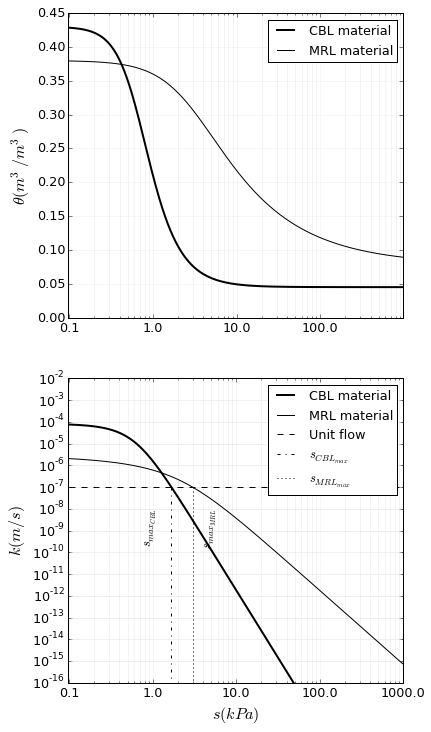

In [55]:
%pylab inline
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
import pandas as pd

#pd.DataFrame(np.transpose(cblModel.wrc()))
data = pd.DataFrame.from_items([('psi', cblModel.wrc()[0]),
                                ('theta', cblModel.wrc()[1])])

fontSize = 16

fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize = fontSize * 0.8)
axes[0].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[0].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
#axes[0].set_xlabel(r'$\psi (m)$')
axes[0].set_ylabel(r'$\theta (m^3/m^3)$', fontsize = fontSize)
axes[0].set_xscale('log')
axes[0].set_xticks([0.1, 1, 10, 100, 1000])
axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes[0].plot(cblModel.wrc()[0] * 9.807, cblModel.wrc()[1], linestyle='-', color = 'black', 
             linewidth=2, label="CBL material")
axes[0].plot(mrlModel.wrc()[0] * 9.807, mrlModel.wrc()[1], linestyle='-', color = 'black', 
             label="MRL material")
legend = axes[0].legend(fontsize = fontSize * 0.8)
frame = legend.get_frame()
frame.set_facecolor('1.00')

axes[1].set_axisbelow(True)
axes[1].tick_params(labelsize = fontSize * 0.8)
axes[1].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[1].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[1].set_xlabel(r'$s (kPa)$', fontsize = fontSize)
axes[1].set_ylabel(r'$k (m/s)$', fontsize = fontSize)
axes[1].set_xscale('log')
axes[1].set_xticks([0.1, 1, 10, 100, 1000])
axes[1].set_yscale('log')
axes[1].set_ylim([1e-16, 1e-2])
axes[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# kFn
axes[1].plot(cblModel.hcf()[0] * 9.807, cblModel.hcf()[1], linestyle='-', linewidth = 2, color = 'black', label="CBL material")
axes[1].plot(mrlModel.hcf()[0] * 9.807, mrlModel.hcf()[1], linestyle='-', color = 'black', label="MRL material")

# Model
axes[1].plot([0.1, 1000], [1e-7, 1e-7], # profileMRL.psiMax
             linestyle='--', color = 'black', label="Unit flow") #  unit flow
axes[1].plot([profileCBL.psiMax * 9.807, profileCBL.psiMax * 9.807], [unit_flow, 1e-16],
             linestyle='-.', color = 'black', label=r'$s_{CBL_{max}}$') 
axes[1].plot([profileMRL.psiMax * 9.807, profileMRL.psiMax * 9.807], [unit_flow, 1e-16], 
             linestyle=':', color = 'black', label=r'$s_{MRL_{max}}$')
axes[1].text(profileCBL.psiMax * 9.807 - 0.9, 5e-9, r"$s_{max_{CBL}}$", 
             fontsize = fontSize * 0.8, color="black", rotation = "vertical")
axes[1].text(profileMRL.psiMax * 9.807 + 1.0, 5e-9, r"$s_{max_{MRL}}$", 
             fontsize = fontSize * 0.8, color="black", rotation = "vertical")

legend = axes[1].legend(fontsize = fontSize * 0.8)
frame = legend.get_frame()
frame.set_facecolor('1.00')
#fig1.savefig('fig1.svg') 

### Graphiques des profils

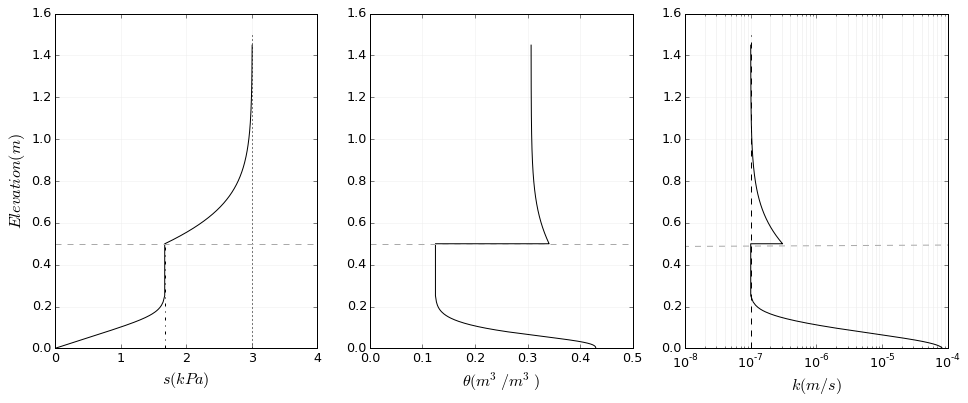

In [56]:
import matplotlib.ticker as plticker

fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

# Suction profile
axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize = fontSize * 0.8)

axes[0].xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))

axes[0].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[0].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[0].set_xlabel(r'$s (kPa)$', fontsize = fontSize)
axes[0].set_ylabel(r'$Elevation (m)$', fontsize = fontSize)
axes[0].plot(np.append(profileCBL.kisch()[0], profileMRL.kisch()[0]) * 9.807,
             np.append(profileCBL.kisch()[1], profileMRL.kisch()[1]),
             linestyle='-', color = 'black')
axes[0].plot([profileCBL.psiMax * 9.807, profileCBL.psiMax * 9.807],
             [0, 0.5],
             linestyle='-.', color = 'black')
axes[0].plot([profileMRL.psiMax * 9.807,profileMRL.psiMax * 9.807],
             [0, 1.5],
             linestyle=':', color = 'black')
axes[0].plot([0, 4.0], [0.5, 0.5], linestyle = "--", color = "#aaaaaa")
#axes[0].text(profileCBL.psiMax * 9.807 - 0.4, 0.8, r"$s_{max_{CBL}} = 1.7 kPa$", 
#             fontsize = fontSize * 0.8, color="black", rotation = "vertical")
#axes[0].text(profileMRL.psiMax * 9.807 + 0.15, 0.8, r"$s_{max_{MRL}} = 3.1 kPa$", 
#             fontsize = fontSize * 0.8, color="black", rotation = "vertical")

# Water content profile
psiInterfaceCBL = np.append(profileCBL.kisch()[0], profileCBL.psiMax)
zInterfaceCBL = np.append(profileCBL.kisch()[1], 0.49999)
cblNew = VanGenuchten(thR = cblthR, thS = cblthS, aVG = cblaVG, nVG = cblnVG, mVG = 1-1/cblnVG, 
                      lVG = cbllVG, ksat = cblksat, psi = psiInterfaceCBL)
mrlNew = VanGenuchten(thR = mrlthR, thS = mrlthS, aVG = mrlaVG, nVG = mrlnVG, mVG = 1-1/mrlnVG, 
                      lVG = mrllVG, ksat = mrlksat, psi = profileMRL.kisch()[0])

axes[1].set_axisbelow(True)
axes[1].tick_params(labelsize = fontSize * 0.8)
axes[1].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[1].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[1].set_xlabel(r'$\theta (m^3/m^3)$', fontsize = fontSize)
axes[1].plot(np.append(cblNew.wrc()[1], mrlNew.wrc()[1]),
             np.append(zInterfaceCBL, profileMRL.kisch()[1]),
             linestyle='-', color = 'black')
axes[1].plot([0, 0.5], [0.5, 0.5], linestyle = "--", color = "#aaaaaa")

# Hydraulic conductivity profile
axes[2].set_axisbelow(True)
axes[2].tick_params(labelsize = fontSize * 0.8)
axes[2].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[2].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[2].set_xlabel(r'$k (m/s)$', fontsize = fontSize)
axes[2].set_xscale('log')
#axes[2].set_xticks([0.1, 1, 10, 100])
axes[2].set_xlim([1e-8, 1e-4])
#axes[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes[2].plot(np.append(cblNew.hcf()[1], mrlNew.hcf()[1]),
             np.append(zInterfaceCBL, profileMRL.kisch()[1]),
             linestyle='-', color = 'black')
axes[2].plot([unit_flow, unit_flow], [0, 1.5], linestyle = "--", color = "black")
axes[2].plot([0, 0.5], [1e-3, 0.5], linestyle = "--", color = "#aaaaaa")
#axes[2].text(4e-8, 0.8, r"$q=10^{-7} m/s$", fontsize = fontSize * 0.8, color="black", rotation = "vertical")
#fig2.savefig('fig2.svg') 

## Drainage latéral dans une barrière capillaire inclinée

Ross (1990) décrit le modèle suivant.

\begin{align}
Q_{max} = \tan(\phi) \int_{\psi_{CBC}}^{\psi_{CRC}} k(\psi) d\psi \\
L = \frac {Q_{max}}{q}
\end{align}

In [39]:
def k_vanGenuchten(x, aVG, nVG, mVG, ksat, lVG = 0.5):
        k = ksat * ((1 - ((aVG * x)**(nVG * mVG)) * \
        ((1 + ((aVG * x)**nVG))**(-mVG)))**2) / \
        ((1 + ((aVG * x)**nVG))**(mVG * lVG))
        return(k)

### Épaisseur minimale de la couche de bris capillaire (CBC ou CBL)

In [40]:
profileCBL.psiMax

0.13977949595681669

### Épaisseur de la couche de rétention capillaire (CRC ou MRL)

In [41]:
pente = 0.25
mrlTh = np.linspace(start = profileCBL.psiMax, stop = 1, num = 100, endpoint = True)
mrlTh
Qmax = []
L = []
for i in range(0, len(mrlTh)):
    Qmax.append(pente * quad(k_vanGenuchten, profileCBL.psiMax, mrlTh[i], args=(mrlaVG, mrlnVG, mrlmVG, mrlksat, mrllVG))[0])
    L.append(Qmax[i] / unit_flow)
#quad(integrand, profileCBL.psiMax, 1, args=(mrlaVG, mrlnVG, mrlmVG, mrlksat, mrllVG))[0]

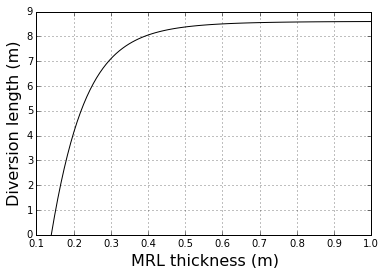

In [42]:
plot(mrlTh, L, color = 'black')
xlabel('MRL thickness (m)', fontsize = fontSize)
ylabel('Diversion length (m)', fontsize = fontSize)
grid()